In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras 
from keras import layers, Model, regularizers
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Generate merchant profiles
def generate_merchants(num_merchants):
    business_types = ['Retail', 'Restaurant', 'E-commerce', 'Services', 'Wholesale']
    gst_status = ['Active', 'Inactive', 'Pending']
    
    merchants = []
    for i in range(num_merchants):
        merchant = {
            'merchant_id': f'M{str(i).zfill(6)}',
            'name': f'Merchant_{i}',
            'business_type': random.choice(business_types),
            'registration_date': (datetime.now() - timedelta(days=random.randint(1, 1000))).date(),
            'gst_status': random.choice(gst_status),
            'is_fraudulent': random.random() < 0.2  # 20% fraudulent merchants
        }
        merchants.append(merchant)
    return pd.DataFrame(merchants)

# Generate transaction data
def generate_normal_transactions(merchant_id, num_days):
    current_date = datetime.now()
    transactions = []
    
    for _ in range(random.randint(50, 200)):  # Random number of transactions
        transaction_date = current_date - timedelta(days=random.randint(0, num_days))
        amount = random.normalvariate(1000, 300)  # Normal distribution
        customer_id = f'C{random.randint(1, 1000)}'
        
        transactions.append({
            'merchant_id': merchant_id,
            'transaction_date': transaction_date,
            'amount': max(10, amount),
            'customer_id': customer_id
        })
    return transactions

def generate_fraudulent_transactions(merchant_id, num_days):
    current_date = datetime.now()
    transactions = []
    fraud_type = random.choice(['late_night', 'high_velocity', 'customer_concentration'])
    
    if fraud_type == 'late_night':
        for _ in range(random.randint(20, 50)):
            transaction_date = current_date - timedelta(days=random.randint(0, num_days))
            transaction_date = transaction_date.replace(
                hour=23 if random.random() < 0.5 else random.randint(0, 4),  # Changed from random.randint(23, 24)
                minute=random.randint(0, 59)
            )
            amount = random.normalvariate(2000, 500)
            customer_id = f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
            
    elif fraud_type == 'high_velocity':
        # Generate high velocity spikes
        spike_day = current_date - timedelta(days=random.randint(0, num_days))
        for _ in range(random.randint(100, 200)):
            transaction_date = spike_day + timedelta(hours=random.randint(0, 24))
            amount = random.normalvariate(1500, 400)
            customer_id = f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
            
    else:  # customer_concentration
        # Generate transactions with high customer concentration
        main_customer = f'C{random.randint(1, 100)}'
        for _ in range(random.randint(50, 150)):
            transaction_date = current_date - timedelta(days=random.randint(0, num_days))
            amount = random.normalvariate(1200, 300)
            customer_id = main_customer if random.random() < 0.8 else f'C{random.randint(1, 1000)}'
            transactions.append({
                'merchant_id': merchant_id,
                'transaction_date': transaction_date,
                'amount': max(10, amount),
                'customer_id': customer_id
            })
    
    return transactions


In [3]:
num_merchants = 1000
merchants_df = generate_merchants(num_merchants)

# Generate transactions for each merchant
all_transactions = []
for _, merchant in merchants_df.iterrows():
    if merchant['is_fraudulent']:
        transactions = generate_fraudulent_transactions(merchant['merchant_id'], 30)
    else:
        transactions = generate_normal_transactions(merchant['merchant_id'], 30)
    all_transactions.extend(transactions)

transactions_df = pd.DataFrame(all_transactions)

In [4]:
transactions_df.to_csv('transactions.csv', index=False)
transactions_df.head()

,merchant_id,transaction_date,amount,customer_id
0,M000000,2024-11-05 02:02:40.403123,1649.894116,C830
1,M000000,2024-10-29 04:28:40.403123,2710.889051,C644
2,M000000,2024-11-09 23:03:40.403123,2242.956350,C514
3,M000000,2024-11-12 02:43:40.403123,1670.633494,C631
4,M000000,2024-11-21 23:50:40.403123,1451.848762,C105


In [5]:

def calculate_merchant_features(transactions_df):
    features = []
    
    for merchant_id in transactions_df['merchant_id'].unique():
        merchant_txns = transactions_df[transactions_df['merchant_id'] == merchant_id]
        
        # Transaction velocity metrics
        daily_txn_counts = merchant_txns.groupby(
            merchant_txns['transaction_date'].dt.date
        ).size().describe()
        
        # Time-based patterns
        hour_distribution = merchant_txns['transaction_date'].dt.hour.value_counts(normalize=True)
        night_hours = [h for h in range(24) if h >= 22 or h <= 4]
        night_txn_ratio = sum(hour_distribution.get(h, 0) for h in night_hours)
        # Amount distributions
        amount_stats = merchant_txns['amount'].describe()
        
        # Customer concentration
        customer_concentration = (
            merchant_txns.groupby('customer_id').size().max() / 
            len(merchant_txns)
        )
        
        features.append({
            'merchant_id': merchant_id,
            'avg_daily_txns': daily_txn_counts['mean'],
            'max_daily_txns': daily_txn_counts['max'],
            'min_daily_txns': daily_txn_counts['min'],
            'std_daily_txns': daily_txn_counts['std'],
            'night_txn_ratio': night_txn_ratio,
            'avg_amount': amount_stats['mean'],
            'std_amount': amount_stats['std'],
            'min_amount': amount_stats['min'],
            'max_amount': amount_stats['max'],
            'customer_concentration': customer_concentration

        })
    
    return pd.DataFrame(features)


In [51]:
features_df = calculate_merchant_features(transactions_df)
feature_columns = features_df.columns.difference(['merchant_id'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_df[feature_columns])


In [54]:
pd.DataFrame(normalized_features, columns=feature_columns).head()

,avg_amount,avg_daily_txns,customer_concentration,max_amount,max_daily_txns,min_amount,min_daily_txns,night_txn_ratio,std_amount,std_daily_txns
0,-0.348530,-0.328222,-0.218977,-0.511130,-0.341155,0.202674,-0.288388,-0.330463,-0.340495,-0.286756
1,-0.394418,-0.177758,-0.268804,0.010631,-0.236066,-0.052946,-0.288388,-0.330463,-0.374111,-0.224783
2,-0.491360,-0.294033,-0.257531,0.197457,-0.271096,-0.492558,-0.288388,-0.330463,-0.243236,-0.256571
3,-0.352645,-0.353234,-0.212909,-0.321857,-0.306125,-0.016740,-0.288388,-0.330463,-0.145036,-0.299617
4,-0.535468,-0.344680,-0.172984,-0.346488,-0.341155,0.563577,-0.288388,-0.330463,-0.385738,-0.291395


In [83]:


def build_complex_autoencoder(input_dim, learning_rate=0.001):
    # Input layer
    input_layer = layers.Input(shape=(input_dim,))
    
    # Encoder
    # First encoding block
    encoded = layers.Dense(64, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01))(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # Second encoding block
    encoded = layers.Dense(32, activation='elu', 
                         kernel_regularizer=regularizers.l2(0.01))(encoded)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # Third encoding block
    encoded = layers.Dense(16, activation='selu')(encoded)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    
    # Bottleneck with attention
    # Self-attention mechanism
    attention = layers.Dense(16, activation='tanh')(encoded)
    attention = layers.Dense(16, activation='softmax')(attention)
    encoded = layers.Multiply()([encoded, attention])
    
    # Bottleneck
    bottleneck = layers.Dense(8, activation='selu')(encoded)
    bottleneck = layers.BatchNormalization()(bottleneck)
    
    # Decoder
    # First decoding block
    decoded = layers.Dense(16, activation='selu')(bottleneck)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # Second decoding block
    decoded = layers.Dense(32, activation='elu', 
                         kernel_regularizer=regularizers.l2(0.01))(decoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # Third decoding block
    decoded = layers.Dense(64, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01))(decoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    
    # Output layer
    output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)
    
    # Create model
    autoencoder = Model(input_layer, output_layer)
    
    # Custom optimizer with learning rate schedule
    initial_learning_rate = learning_rate
    decay_steps = 1000
    decay_rate = 0.9
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True)
    
    optimizer = Adam(learning_rate=learning_rate)  
    
    # Compile model with custom loss function
    def custom_loss(y_true, y_pred):
        mse_loss = tf.keras.losses.mse(y_true, y_pred)
        l1_loss = 0.01 * tf.reduce_mean(tf.abs(y_pred))
        return mse_loss + l1_loss

    autoencoder.compile(optimizer=optimizer, loss=custom_loss, 
                       metrics=['mae', 'mse'])
    
    return autoencoder

# Create and train the model
input_dim = normalized_features.shape[1]
autoencoder = build_complex_autoencoder(input_dim)

# Model training with early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)



In [84]:

# Train the model with callbacks
history = autoencoder.fit(
    normalized_features, 
    normalized_features,
    epochs=200,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.4694 - mae: 0.9317 - mse: 1.2886 - val_loss: 2.3477 - val_mae: 0.9187 - val_mse: 1.2542 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2627 - mae: 0.8913 - mse: 1.1953 - val_loss: 2.1877 - val_mae: 0.8754 - val_mse: 1.1960 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0608 - mae: 0.8445 - mse: 1.0918 - val_loss: 2.0214 - val_mae: 0.8172 - val_mse: 1.1218 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8305 - mae: 0.7841 - mse: 0.9518 - val_loss: 1.8686 - val_mae: 0.7552 - val_mse: 1.0549 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6286 - mae: 0.7203 - mse: 0.8342 - val_loss: 1.7434 - val_mae: 0.7026 - val_mse: 1.0102 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4812 - mae: 0.6738 - mse: 0.7655 - val_loss: 1.6338 - val_mae: 0.6624 - v

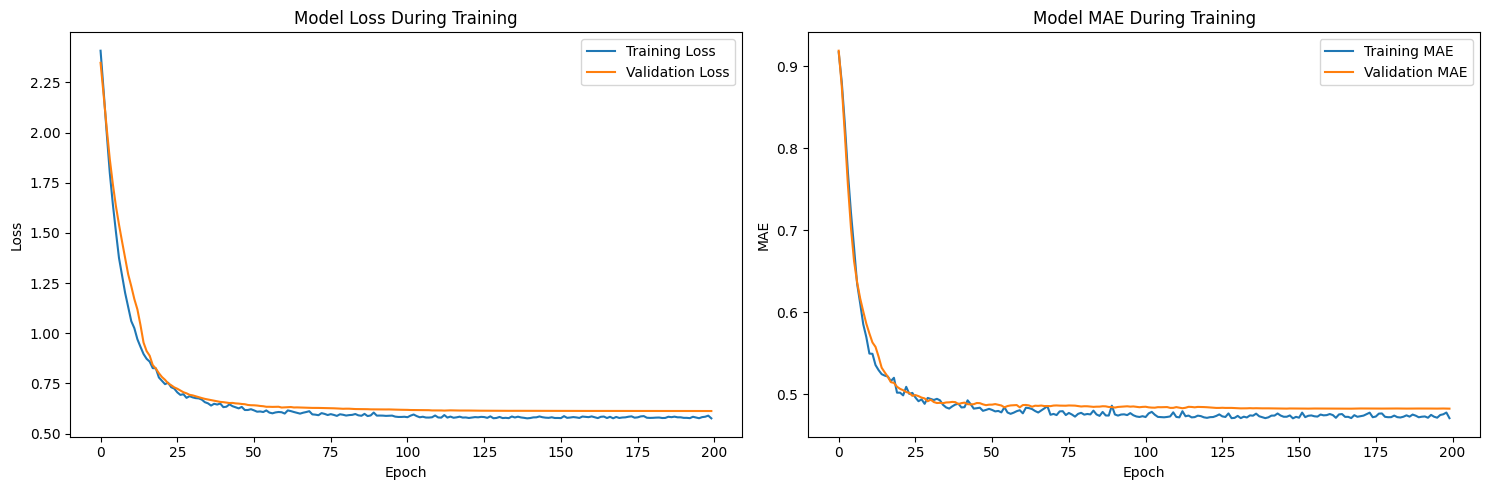

In [85]:

# Plot training history with multiple metrics
plt.figure(figsize=(15, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [86]:
reconstructed = autoencoder.predict(normalized_features)
mse = np.mean(np.power(normalized_features - reconstructed, 2), axis=1)
threshold = np.percentile(mse, 95)  # 95th percentile as threshold
anomaly_scores = mse / threshold  # Normalized anomaly scores


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [87]:
def detect_patterns(features_df, anomaly_scores):
    patterns = []
    
    velocity_threshold = 3.0  # Standard deviations above mean
    night_ratio_threshold = 0.3
    concentration_threshold = 0.5
    
    for idx, row in features_df.iterrows():
        merchant_patterns = []
        
        # High velocity detection
        if (row['max_daily_txns'] - row['avg_daily_txns']) / row['std_daily_txns'] > velocity_threshold:
            merchant_patterns.append('high_velocity')
            
        # Odd-hour pattern detection
        if row['night_txn_ratio'] > night_ratio_threshold:
            merchant_patterns.append('odd_hours')
            
        # Customer concentration analysis
        if row['customer_concentration'] > concentration_threshold:
            merchant_patterns.append('customer_concentration')
            
        patterns.append({
            'merchant_id': row['merchant_id'],
            'anomaly_score': anomaly_scores[idx],
            'detected_patterns': merchant_patterns,
            'is_suspicious': anomaly_scores[idx] > 1.0 or len(merchant_patterns) > 0
        })
    
    return pd.DataFrame(patterns)

# Detect patterns
results = detect_patterns(features_df, anomaly_scores)



Suspicious Merchants:
    merchant_id  anomaly_score         detected_patterns
3       M000003       0.025657           [high_velocity]
6       M000006       0.064330           [high_velocity]
15      M000015       1.350437               [odd_hours]
16      M000016       1.936861                        []
17      M000017       0.345529  [customer_concentration]
..          ...            ...                       ...
990     M000990       0.257905  [customer_concentration]
991     M000991       0.034572           [high_velocity]
997     M000997       0.052926           [high_velocity]
998     M000998       0.076174           [high_velocity]
999     M000999       0.023857           [high_velocity]

[223 rows x 3 columns]


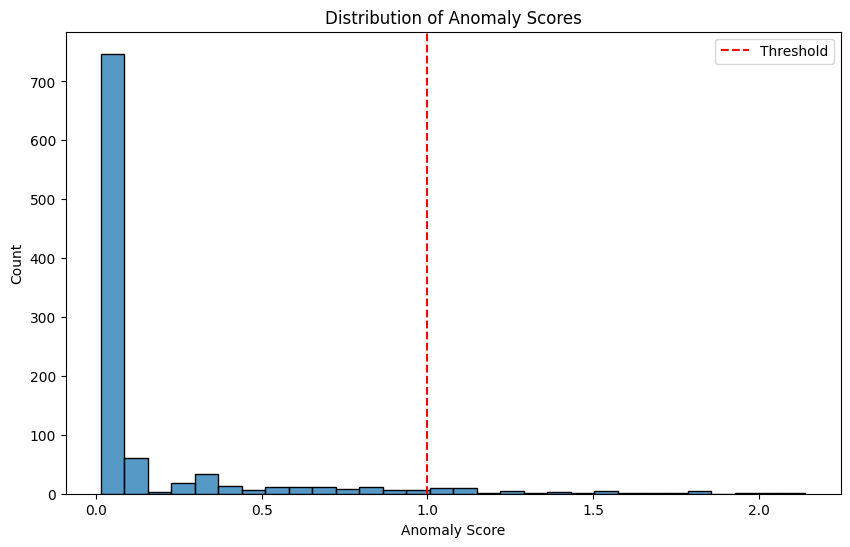

In [88]:
# Display suspicious merchants
suspicious_merchants = results[results['is_suspicious']]
print("\nSuspicious Merchants:")
print(suspicious_merchants[['merchant_id', 'anomaly_score', 'detected_patterns']])

# Plot anomaly score distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=results, x='anomaly_score', bins=30)
plt.axvline(x=1.0, color='r', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.legend()
plt.show()


In [91]:
# Compare detected fraud with actual fraudulent merchants
results['actual_fraudulent'] = results['merchant_id'].map(
    merchants_df.set_index('merchant_id')['is_fraudulent']
)

# Calculate detection metrics
true_positives = sum((results['is_suspicious']) & (results['actual_fraudulent']))
false_positives = sum((results['is_suspicious']) & (~results['actual_fraudulent']))
false_negatives = sum((~results['is_suspicious']) & (results['actual_fraudulent']))
true_negatives = sum((~results['is_suspicious']) & (~results['actual_fraudulent']))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

print("\nDetection Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")



Detection Metrics:
Precision: 0.70
Recall: 0.83
F1 Score: 0.76


In [92]:
autoencoder.save('merchant_fraud_detector.h5')

# Save the scaler
import joblib
joblib.dump(scaler, 'feature_scaler.pkl')

# Save results
results.to_csv('fraud_detection_results.csv', index=False)
print("\nModel and results saved successfully!")


Model and results saved successfully!
